<a href="https://colab.research.google.com/github/Peheppy/Titanic_survivors_prediction_with_MLP/blob/main/Titanic_with_MLPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic with MLPs


## Instalação e Importações

In [ ]:
%%capture
!pip install torchinfo
!mkdir -p logs

import torch
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import json
import random
from tqdm import tqdm
from typing import Sequence, Callable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

sns.set_style('darkgrid')

Configuração Inicial

In [ ]:
# Load the Titanic dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Combine for preprocessing
full_df = pd.concat([train_df, test_df], axis=0)

# Display dataset info
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
train_df.head()

Train dataset shape: (891, 12)
Test dataset shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Dataset Setup

In [ ]:
# Handle missing values
def preprocess_data(df):
    # Make a copy to avoid modifying the original
    df = df.copy()

    # Fill missing ages with median
    if 'Age' in df.columns:
        df['Age'] = df['Age'].fillna(df['Age'].median())

    # Fill missing fare with median
    if 'Fare' in df.columns:
        df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    # Fill missing embarked with mode
    if 'Embarked' in df.columns:
        df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Create new features only if the required columns exist
    if all(col in df.columns for col in ['SibSp', 'Parch']):
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
        df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Extract title from name if Name column exists
    if 'Name' in df.columns:
        df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        # Group rare titles
        if 'Title' in df.columns:
            df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                                             'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
            df['Title'] = df['Title'].replace('Mlle', 'Miss')
            df['Title'] = df['Title'].replace('Ms', 'Miss')
            df['Title'] = df['Title'].replace('Mme', 'Mrs')

    # Drop columns we won't use (only if they exist)
    cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    for col in cols_to_drop:
        if col in df.columns:
            df = df.drop(col, axis=1)

    return df

# Apply preprocessing
full_df = preprocess_data(full_df)

# Split back into train and test
train_df = full_df[:len(train_df)]
test_df = full_df[len(train_df):].drop('Survived', axis=1) if 'Survived' in full_df.columns else full_df[len(train_df):]

# Display the processed data
print("\nProcessed Training Data:")
print(train_df.head())
print("\nProcessed Test Data:")
print(test_df.head())


Processed Training Data:
   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  FamilySize  \
0       0.0       3    male  22.0      1      0   7.2500        S           2   
1       1.0       1  female  38.0      1      0  71.2833        C           2   
2       1.0       3  female  26.0      0      0   7.9250        S           1   
3       1.0       1  female  35.0      1      0  53.1000        S           2   
4       0.0       3    male  35.0      0      0   8.0500        S           1   

   IsAlone Title  
0        0    Mr  
1        0   Mrs  
2        1  Miss  
3        0   Mrs  
4        1    Mr  

Processed Test Data:
   Pclass     Sex   Age  SibSp  Parch     Fare Embarked  FamilySize  IsAlone  \
0       3    male  34.5      0      0   7.8292        Q           1        1   
1       3  female  47.0      1      0   7.0000        S           2        0   
2       2    male  62.0      0      0   9.6875        Q           1        1   
3       3    male  27.0      0 

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

aaaaa


In [ ]:
# Configuração de dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo selecionado: {device}")

# Função para setar seed
def set_seed(seed):
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(False)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

Dispositivo selecionado: cuda


## Model definition (MLP)

In [ ]:
class MLP(nn.Module):
    def __init__(
            self,
            input_size: int,
            num_classes: int = 2,
            activation_function: Callable = nn.ReLU(),
            layer_sizes: Sequence[int] = [64, 32],
            dropout_rate: float = 0.3
        ):
        super().__init__()

        sizes = [input_size, *layer_sizes, num_classes]
        layers = []

        for i in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if i < len(layer_sizes):
                layers.append(nn.LayerNorm(sizes[i+1]))
                layers.append(activation_function)
                layers.append(nn.Dropout(dropout_rate))

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        return self.classifier(x)

# Classes Auxiliares

In [ ]:
class AverageMeter:
    """Computa e armazena média e valor atual"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Training Utilities

In [ ]:
def train_step(model, train_dl, loss_fn, optimizer, device):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()

    for x, y in tqdm(train_dl, desc="Training", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        acc = (preds == y).float().mean()
        train_loss.update(loss.item(), x.size(0))
        train_acc.update(acc.item(), x.size(0))

    return train_loss.avg, train_acc.avg

In [ ]:
def eval_step(model, dl, loss_fn, device, name="Validation"):
    model.eval()
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()

    with torch.no_grad():
        for x, y in tqdm(dl, desc=name, leave=False):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = loss_fn(outputs, y)
            preds = outputs.argmax(dim=1)
            acc = (preds == y).float().mean()
            loss_meter.update(loss.item(), x.size(0))
            acc_meter.update(acc.item(), x.size(0))

    return loss_meter.avg, acc_meter.avg

# Configurações dos Experimentos

In [ ]:
base_config = {
    "input_size": 9,
    "num_classes": 2,
    "n_epochs": 100,
    "bs_train": 32,
    "bs_val_test": 64,
    "loss_fn": nn.CrossEntropyLoss(),
    "patience": 10
}

In [ ]:
model_configs = [
    {
        "name": "Baseline",
        "learning_rate": 1e-3,
        "optimizer": torch.optim.Adam,
        "activation_fn": nn.ReLU(),
        "layer_sizes": [64, 32],
        "dropout_rate": 0.3
    },
    {
        "name": "DeeperNet",
        "learning_rate": 5e-4,
        "optimizer": torch.optim.Adam,
        "activation_fn": nn.LeakyReLU(),
        "layer_sizes": [128, 64, 32],
        "dropout_rate": 0.4
    },
    {
        "name": "WideNet",
        "learning_rate": 1e-3,
        "optimizer": torch.optim.RMSprop,
        "activation_fn": nn.Tanh(),
        "layer_sizes": [256, 128],
        "dropout_rate": 0.2
    }
]

In [ ]:

# Combinar com configuração base
for config in model_configs:
    config.update(base_config)

 # Classe de Experimentos

In [ ]:
class ModelExperiment:
    def __init__(self, config):
        self.config = config
        self.model = MLP(
            input_size=config["input_size"],
            num_classes=config["num_classes"],
            activation_function=config["activation_fn"],
            layer_sizes=config["layer_sizes"],
            dropout_rate=config["dropout_rate"]
        ).to(device)
        self.history = {
            "train_loss": [], "train_acc": [],
            "val_loss": [], "val_acc": [],
            "lr": []  # Adicionamos o histórico de learning rate
        }

    def run(self, train_dl, val_dl, test_dl=None):
        print(f"\n{'='*50}")
        print(f"Treinando modelo: {self.config['name']}")
        print(f"Configuração: {self.config}\n")

        optimizer = self.config["optimizer"](
            self.model.parameters(), lr=self.config["learning_rate"])

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', patience=5)

        early_stop = EarlyStopping(patience=self.config["patience"])

        for epoch in range(self.config["n_epochs"]):
            train_loss, train_acc = train_step(
                self.model, train_dl, self.config["loss_fn"], optimizer, device)
            val_loss, val_acc = eval_step(
                self.model, val_dl, self.config["loss_fn"], device)

            # Registrar learning rate atual
            current_lr = optimizer.param_groups[0]['lr']

            # Atualizar histórico
            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)
            self.history["lr"].append(current_lr)

            # Atualizar scheduler e early stopping
            scheduler.step(val_loss)
            early_stop(val_loss)

            print(f"Epoch {epoch+1}/{self.config['n_epochs']} | "
                  f"LR: {current_lr:.2e} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if early_stop.early_stop:
                print("Early stopping acionado!")
                break

        # Avaliação final
        if test_dl:
            test_loss, test_acc = eval_step(
                self.model, test_dl, self.config["loss_fn"], device, "Testing")
            print(f"\nResultados Finais - Loss: {test_loss:.4f} Acc: {test_acc:.4f}")
            self.history["test_loss"] = test_loss
            self.history["test_acc"] = test_acc

        return self

# Execução dos Experimentos

In [ ]:
# Preparar DataLoaders
train_dl = torch.utils.data.DataLoader(
    train_dataset, batch_size=base_config["bs_train"], shuffle=True)
val_dl = torch.utils.data.DataLoader(
    val_dataset, batch_size=base_config["bs_val_test"], shuffle=False)
test_dl = torch.utils.data.DataLoader(
    test_dataset, batch_size=base_config["bs_val_test"], shuffle=False)

# Executar experimentos
experiments = []
for config in model_configs:
    experiment = ModelExperiment(config).run(train_dl, val_dl)
    experiments.append(experiment)

NameError: name 'train_dataset' is not defined

# Visualização dos Resultados

In [ ]:
def plot_results(experiments, metric='loss'):
    plt.figure(figsize=(12, 6))
    for exp in experiments:
        plt.plot(exp.history[f'train_{metric}'], label=f"{exp.config['name']} - Train")
        plt.plot(exp.history[f'val_{metric}'], '--', label=f"{exp.config['name']} - Val")
    plt.title(f'Comparação de Modelos - {metric.capitalize()}')
    plt.xlabel('Época')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_learning_rates(experiments):
    plt.figure(figsize=(12, 6))
    for exp in experiments:
        plt.plot(exp.history['lr'], label=exp.config['name'])
    plt.title('Evolução do Learning Rate')
    plt.xlabel('Época')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

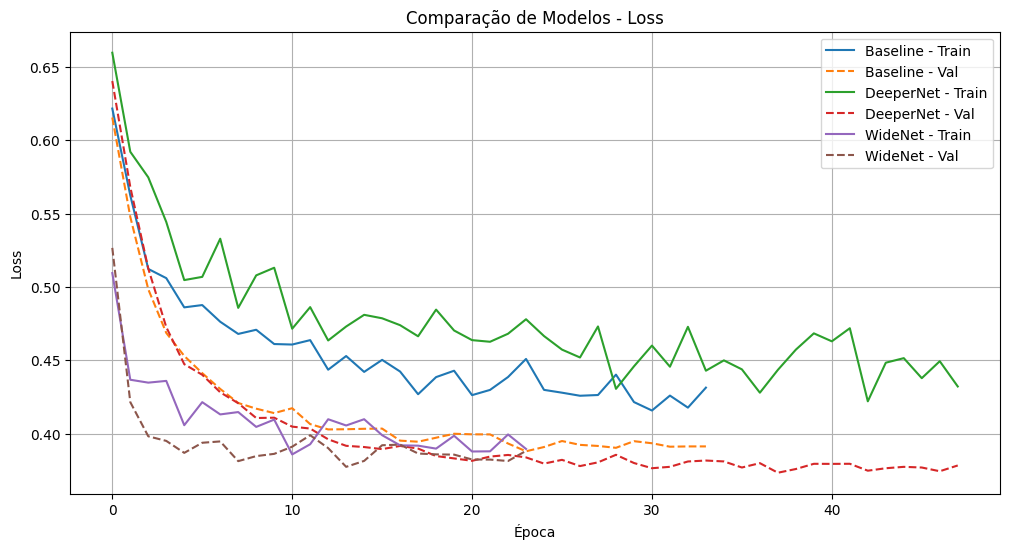

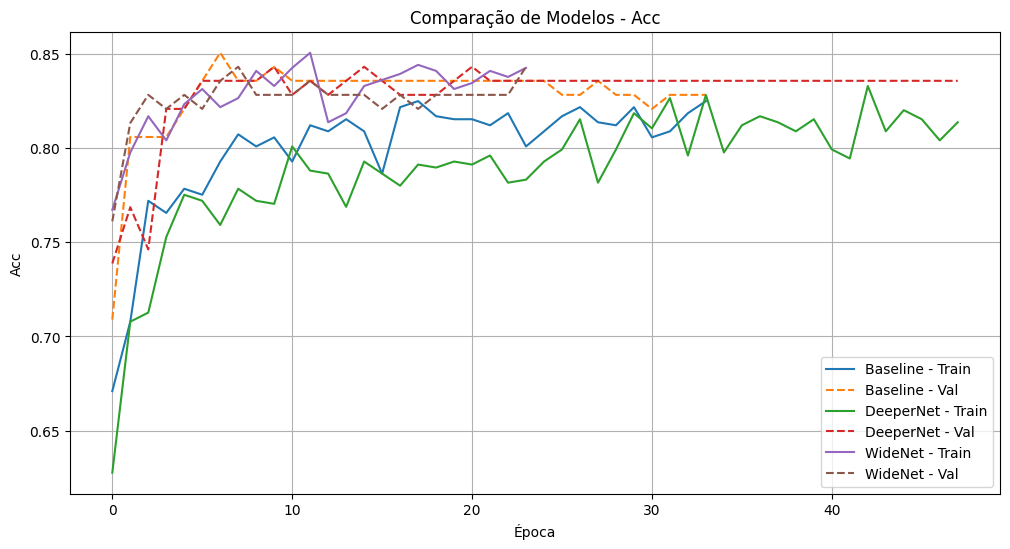

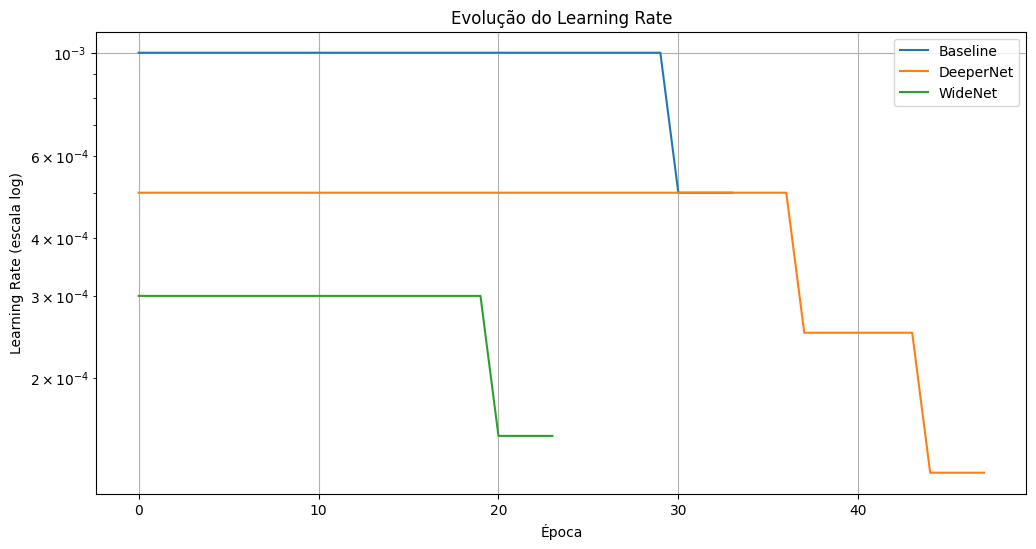

In [ ]:
plot_results(experiments, 'loss')
plot_results(experiments, 'acc')
plot_learning_rates(experiments)

In [ ]:
results = []
for exp in experiments:
    res = {
        "Modelo": exp.config["name"],
        "Arquitetura": str(exp.config["layer_sizes"]),
        "Optimizer": exp.config["optimizer"].__name__,
        "LR Inicial": exp.config["learning_rate"],
        "LR Final": exp.history["lr"][-1],
        "Max Train Acc": f"{max(exp.history['train_acc'])*100:.2f}%",
        "Max Val Acc": f"{max(exp.history['val_acc'])*100:.2f}%",
        "Test Acc": f"{exp.history.get('test_acc', 0)*100:.2f}%",
        "Épocas": len(exp.history['train_loss'])
    }
    results.append(res)


Resumo Comparativo dos Modelos:


,Modelo,Arquitetura,Optimizer,LR Inicial,LR Final,Max Train Acc,Max Val Acc,Test Acc,Épocas
0,Baseline,"[64, 32]",Adam,0.001000,0.000500,82.50%,85.07%,81.34%,34
1,DeeperNet,"[128, 64, 32]",AdamW,0.000500,0.000125,83.31%,84.33%,81.34%,48
2,WideNet,"[256, 128]",RMSprop,0.000300,0.000150,85.07%,84.33%,81.34%,24


In [ ]:

results_df = pd.DataFrame(results)
print("\nResumo Comparativo dos Modelos:")
display(results_df.style.background_gradient(cmap='Blues'))

# Salvar Resultados

In [ ]:
# Criar diretório para salvar resultados
!mkdir -p results

In [ ]:
# Salvar resultados em CSV
results_df.to_csv("results/model_comparison.csv", index=False)

In [ ]:
# Salvar modelos e históricos
for exp in experiments:
    model_name = exp.config["name"].replace(" ", "_").lower()
    # Salvar modelo
    torch.save(exp.model.state_dict(), f"results/{model_name}_model.pth")
    # Salvar histórico
    with open(f"results/{model_name}_history.json", 'w') as f:
        json.dump(exp.history, f)

print("Resultados salvos na pasta 'results'")

Resultados salvos na pasta 'results'
